# Spin dynamics

In [ ]:
## imports
 
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import *

## System described here

We want to describe our system as it will be at first on the benchtop version.
We have the laser and the rf field $B_1$ along the z axis, the field to measure $B_0$ along the x axis.

$$ \partial_t \begin{pmatrix} M_x \\ M_y \\ M_z \end{pmatrix} = \begin{pmatrix} M_x \\ M_y \\ M_z \end{pmatrix} \wedge \begin{pmatrix} \gamma B_0 \\ 0 \\ \gamma B_{rf}\cos(\omega_{rf} t) \end{pmatrix} - \Gamma \begin{pmatrix} M_x \\ M_y \\ M_z \end{pmatrix} + R_{op} \begin{pmatrix}-M_x \\ -M_y \\ M_0-M_z\end{pmatrix} $$


$$
\partial_t \begin{pmatrix} M_x \\ M_y \\ M_z \end{pmatrix} =
\begin{pmatrix} 
\gamma B_{rf} \cos(\omega_{rf} t) M_y  \\ 
\gamma B_0 M_z - \gamma B_{rf} \cos(\omega_{rf} t) M_x  \\ 
- \gamma B_0 M_y 
\end{pmatrix}
- \Gamma \begin{pmatrix} M_x \\ M_y \\ M_z \end{pmatrix}
+ R_{op} \begin{pmatrix} -M_x \\ -M_y \\ M_0 - M_z \end{pmatrix}.
$$


In [ ]:
## Constants
gamma = 7e9    # Gyromagnetic ratio (Hz/T)
sigma = 1.082e-13 #m^2 from Table 7, [1]

## Parameters
Gamma = 2000    # Relaxation rate (Hz)
R_op = 3.07e7   # Optical pumping rate (Hz)

B_0 = 100e-9    # Static field intensity (Tesla)
B_1 = 1e-3      # RF field intensity (Tesla)

P_laser = 0.2e-3 # Laser power (W)
beam_diameter = 1e-3 # self-explanatory (m)

P = 3e-1        # Cell pressure (Pa)
V = 3e-3*3e-3*1.9e-3 # Cell volume (m^3)
z_cell = 1.9e-2 # Cell length (m)
T = 273.15+60   # Cell temperature (K)

## Derived parameters
omega = gamma * B_0   # Frequency of the RF field (Hz)
I_0 = P_laser/(np.pi*(beam_diameter/2)**2) # Laser intensity before the cell (W/m²)
n = P/(k*T)     # Rb density (m^-3)
N = P*V/(k*T) # Number of particles
M_0 = 1 #* N * mu_0       # maximum magnetization


$$
\partial_t \begin{pmatrix} M_x \\ M_y \\ M_z \end{pmatrix} =
\begin{pmatrix} 
\gamma B_{rf} \cos(\omega_{rf} t) M_y  \\ 
\gamma B_0 M_z - \gamma B_{rf} \cos(\omega_{rf} t) M_x  \\ 
- \gamma B_0 M_y 
\end{pmatrix}
- \Gamma \begin{pmatrix} M_x \\ M_y \\ M_z \end{pmatrix}
+ R_{op} \begin{pmatrix} -M_x \\ -M_y \\ M_0 - M_z \end{pmatrix}.
$$


In [ ]:
def bloch_equations(t, M, gamma, B_0, B_1, omega, Gamma, R_op, M_0):
    Mx, My, Mz = M
    cos_omega_t = np.cos(omega * t)
    term1 = B_1 * cos_omega_t
    term2 = B_0 

    dMxdt = gamma * term1 * My - (Gamma + R_op) * Mx
    dMydt = gamma * term2 * Mz - gamma * term1 * Mx - (Gamma + R_op) * My
    dMzdt = - gamma * term2 * My - (Gamma) * Mz + R_op * (M_0 - Mz)
    return [dMxdt, dMydt, dMzdt]

def solve_bloch_equations(initial_state, t_span, t_eval, gamma, B_0, B_1, omega, Gamma, R_op, M_0):
    solution = solve_ivp(
        bloch_equations,
        t_span,
        initial_state,
        method='BDF',  
        t_eval=t_eval,
        args=(gamma, B_0, B_1, omega, Gamma, R_op, M_0)
    )
    return solution

initial_state = [0, 0, 0]
t_span = [0, 10]
sampling_rate = 1000000
t_eval = np.linspace(t_span[0], t_span[1], sampling_rate)  

solution = solve_bloch_equations(initial_state, t_span, t_eval, gamma = gamma, B_0 = B_0, B_1 = B_1, omega = omega, Gamma = Gamma, R_op = R_op, M_0=M_0)

t = solution.t
Mx, My, Mz = solution.y

print(f"Final Mx: {Mx[-1]:.4f}")
print(f"Final My: {My[-1]:.4f}")
print(f"Final Mz: {Mz[-1]:.4f}")

Final Mx: 499551.5123
Final My: 25417311.8753
Final Mz: 1115233926782.5559


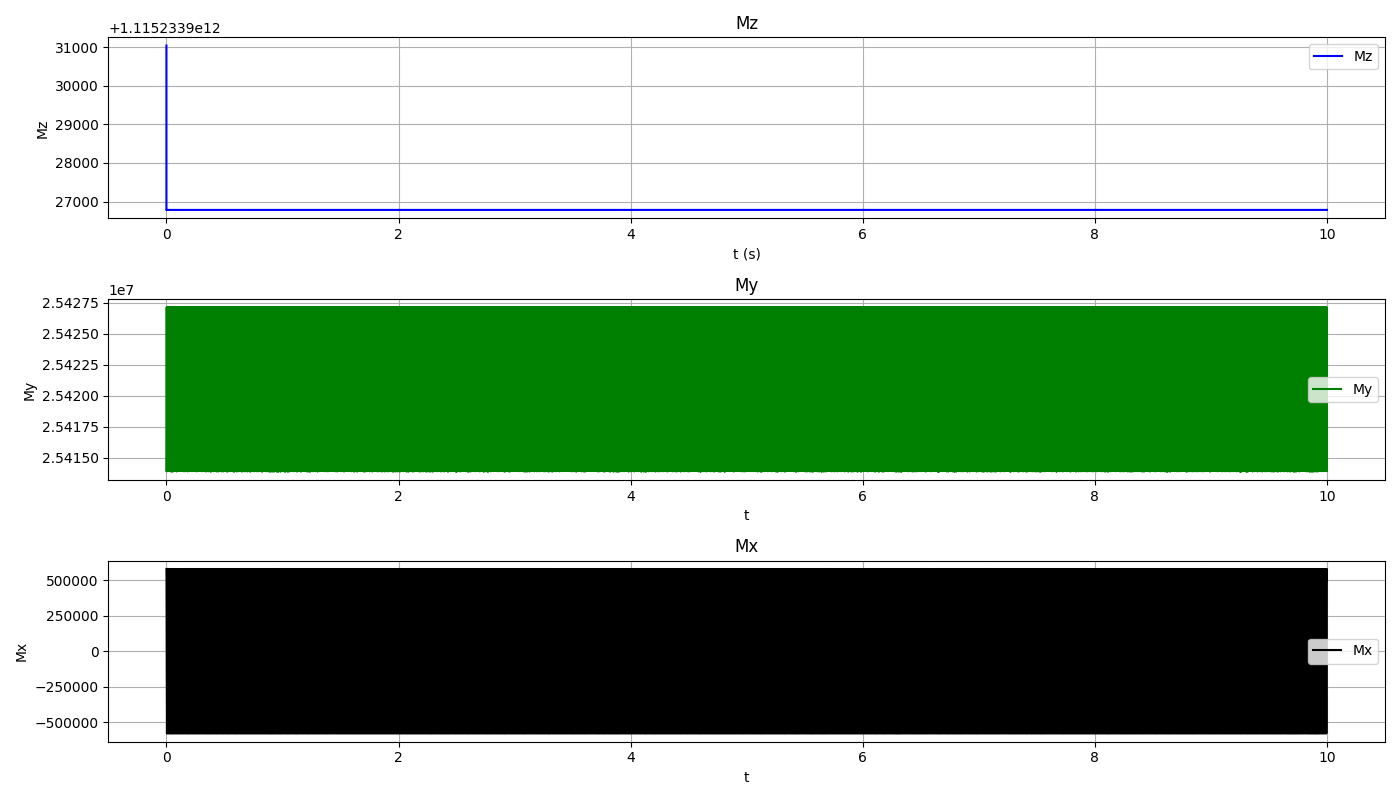

In [13]:
%matplotlib widget
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

points_to_skip = 1

# First subplot: sine function
axes[0].plot(t[points_to_skip:], Mz[points_to_skip:], color='blue', label='Mz')
axes[0].set_title('Mz')
axes[0].set_xlabel('t (s)')
axes[0].set_ylabel('Mz')
axes[0].legend()
axes[0].grid(True)

# Third subplot: double frequency sine function
axes[1].plot(t[points_to_skip:], My[points_to_skip:], color='green', label='My')
axes[1].set_title('My')
axes[1].set_xlabel('t')
axes[1].set_ylabel('My')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t[points_to_skip:], Mx[points_to_skip:], color='black', label='Mx')
axes[2].set_title('Mx')
axes[2].set_xlabel('t')
axes[2].set_ylabel('Mx')
axes[2].legend()
axes[2].grid(True)

# Adjust the layout so titles and labels do not overlap
plt.tight_layout()

# Display the interactive widget
plt.show()

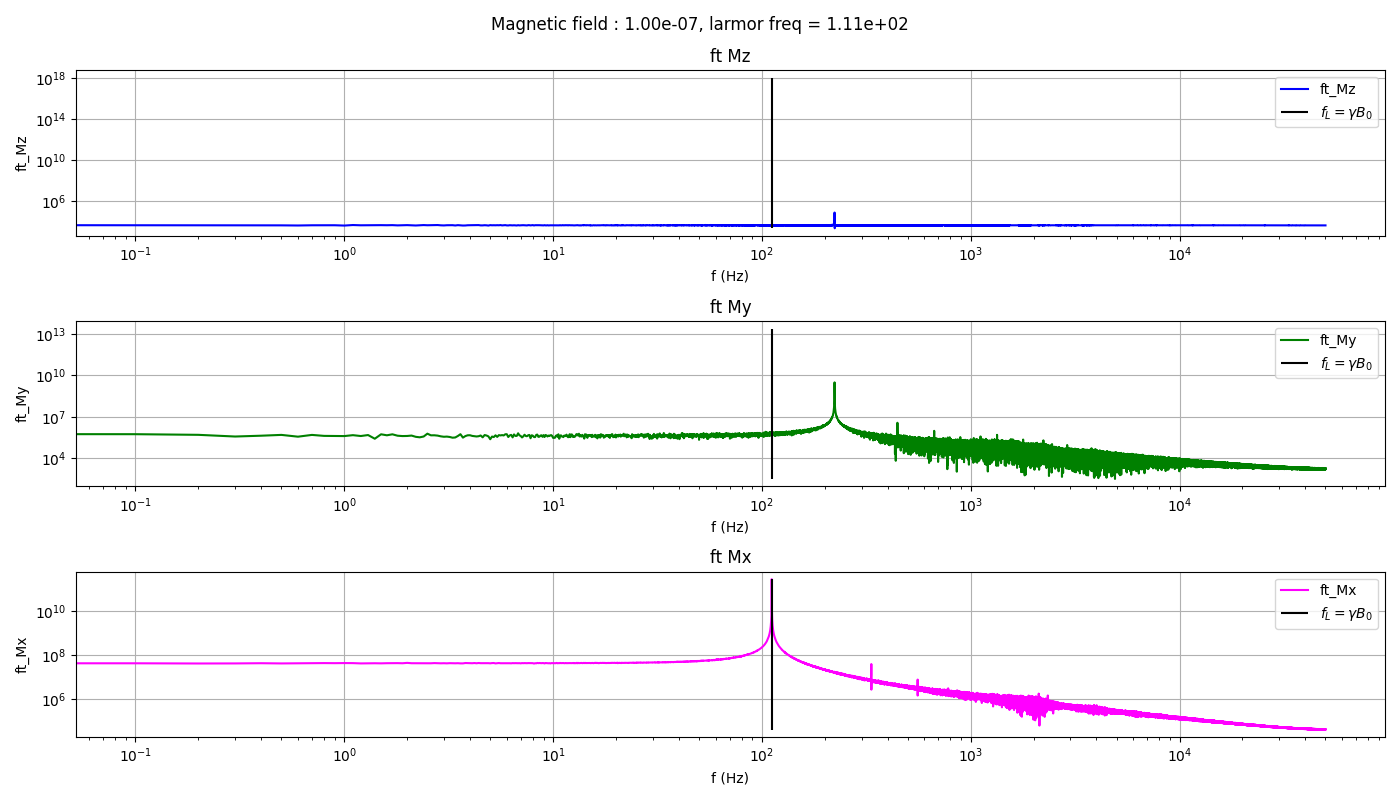

In [3]:
dt = t_eval[1]-t_eval[0]
freq = np.fft.rfftfreq(len(t_eval[points_to_skip:]), d=dt)
#freq_shifted = np.abs(np.fft.fftshift(freq))

ft_Mz = np.abs(np.fft.rfft(Mz[points_to_skip:]))
ft_My = np.abs(np.fft.rfft(My[points_to_skip:]))
ft_Mx = np.abs(np.fft.rfft(Mx[points_to_skip:]))

masked_freq = freq <=25e3

masked_ft_Mz = ft_Mz[np.where(masked_freq==True)]
masked_ft_My = ft_My[np.where(masked_freq==True)]
masked_ft_Mx = ft_Mx[np.where(masked_freq==True)]

peaks_Mz, _ = find_peaks(masked_ft_Mz, height=1e2)
peaks_My, _ = find_peaks(masked_ft_My, height=1e2)
peaks_Mx, _ = find_peaks(masked_ft_Mx, height=1e-1)

noise_spectrum_signal_Mz = np.delete(masked_ft_Mz,peaks_Mz)
average_noise_Mz = np.mean(noise_spectrum_signal_Mz[1:])
noise_spectrum_signal_My = np.delete(masked_ft_My,peaks_My)
average_noise_My = np.mean(noise_spectrum_signal_My[1:])
noise_spectrum_signal_Mx = np.delete(masked_ft_Mx,peaks_Mx)
average_noise_Mx = np.mean(noise_spectrum_signal_Mx[1:])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

fig.suptitle('Magnetic field : {:.2e}, larmor freq = {:.2e}'.format(B_0, gamma*B_0/(2*np.pi)))

axes[0].plot(freq, ft_Mz, color='blue', label='ft_Mz')
axes[0].vlines(gamma*B_0/(2*np.pi), min(ft_Mz), max(ft_Mz), color = 'k', label='$f_{L} = \gamma B_0 $')
#axes[0].axhline(average_noise_Mz, color = 'r', label = 'noise floor = {:.2e}'.format(average_noise_Mz))
#axes[0].plot(freq[peaks_Mz], ft_Mz[peaks_Mz], 'x', label = 'peak value = {:.2e}\npeak position = {:.2e}'.format(float(ft_Mz[peaks_Mz]), float(freq[peaks_Mz])))
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('ft Mz')
axes[0].set_xlabel('f (Hz)')
axes[0].set_ylabel('ft_Mz')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(freq, ft_My, color='green', label='ft_My')
axes[1].vlines(gamma*B_0/(2*np.pi), min(ft_My), max(ft_My), color = 'k', label='$f_{L} = \gamma B_0 $')
#axes[1].axhline(average_noise_My, color = 'r', label = 'noise floor = {:.2e}'.format(average_noise_My))
#axes[1].plot(freq[peaks_My], ft_My[peaks_My], 'x', label = 'peak value = {:.2e}\npeak position = {:.2e}'.format(float(ft_My[peaks_My]), float(freq[peaks_My])))
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('ft My')
axes[1].set_xlabel('f (Hz)')
axes[1].set_ylabel('ft_My')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(freq, ft_Mx, color='magenta', label='ft_Mx')
axes[2].vlines(gamma*B_0/(2*np.pi), min(ft_Mx), max(ft_Mx), color = 'k', label='$f_{L} = \gamma B_0 $')
#axes[2].axhline(average_noise_Mx, color = 'r', label='noise floor = {:.2e}'.format(average_noise_Mx))
#axes[2].plot(freq[peaks_Mx], ft_Mx[peaks_Mx], 'x', label = 'peak value = {:.2e}\npeak position = {:.2e}'.format(float(ft_Mx[peaks_Mx]), float(freq[peaks_Mx])))
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_title('ft Mx')
axes[2].set_xlabel('f (Hz)')
axes[2].set_ylabel('ft_Mx')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

## Discussions

The factor 2 between the frequency observed in $M_z$ and the Larmor frequency remains unexplained. 
The simulation seems believable otherwise.

# Light absorption of the system

## Equations and system described


In [2] is given the differential equation for the light intensity across the vapour cell :

$$\partial_z I(z) = -n \sigma(\nu) I(z) (1-sM_z)$$
Where : 
- n is the density of alkali-metal atoms; $n = \frac{1}{T}10^{21.866+A - \tfrac{B}{T}}$
- $\sigma(\nu)$ is the photon absorption cross section
- s is the photon polarization
- $M_z$ is the magnetization on the z-axis 

In the very same paper, they derive this into the following expression :

$$I(z) =  \frac{k_s h \nu}{\sigma(\nu)}\Gamma W \left[\frac{\sigma(\nu)}{k_s h \nu} \frac{I(0)}{\Gamma} e^{\frac{\sigma(\nu)}{k_s h \nu} \frac{I(0)}{\Gamma} - n\sigma(\nu)z} \right]$$
where :
- $k_s$ is the loss parameter due to glass walls
- W is the lambert-W function define as the solution of the equation $we^w = y$

We will try to solve the first equation, and then get the result from the second result and see what makes sense.

Solving $\partial_z I(z) = -n \sigma(\nu) I(z) (1-sM_z)$ <br>
We know $M_z = M_z(t)$, we can easily solve this equation considering that light goes a lot faster than our polarization change (i.e. we can treat separately the space and time part of this equation).
$$I(z,t) = I(0,t) e^{- \left[n\sigma(1-M_z(t))z \right]}$$

In [ ]:
def absorption_equation(z, I_0, sigma, n, Mz):
    I = I_0 * np.exp(-n*sigma*(Mz)*z)
    return I

I_z_t = np.zeros(len(Mz))
test = np.zeros(len(Mz))

for i, Mz_t in enumerate(Mz):
    I_z_t[i] = absorption_equation(z = z_cell, I_0 = I_0, sigma = sigma, n=n, Mz= Mz_t)
    test[i] = -n*sigma*(1-Mz_t)*z_cell

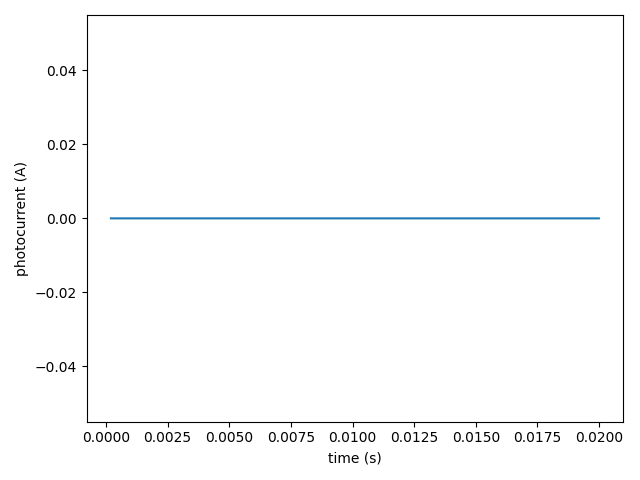

In [ ]:
R = 0.568 #A/W, for standard thorlabs Si photodiode

P_z_t = I_z_t * (np.pi*(beam_diameter/2)**2)
photocurrent_z_t = R*P_z_t

fig,axes=plt.subplots()
axes.plot(t[20:2000],photocurrent_z_t[20:2000])
axes.set_xlabel('time (s)')
axes.set_ylabel('photocurrent (A)')
plt.tight_layout()
plt.show()

# Sources



[1] : 'Rubidium 87 D Line Data', Daniel A. Steck <br>
[2] : "In-situ measurement and close-loop control of atomic number density in an optically pumped magnetometer based on light absorption", ZiaoLiu et al 2023